In [1]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib.collections import LineCollection
import seaborn as sns

import trompy as tp
import csv


colors_restricted = "#219C90"
colors_adlib_light = "#9C89B8" 
colors_adlib_dark = "#0059b3"
colors_sucralose = "#af9991"

In [2]:
DATAFOLDER = Path("C:/Data/hislight_pickles/")
FIGSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/figures")
STATSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/stats")

with open(DATAFOLDER / "restricted_dark.pickle", 'rb') as handle:
    PVH_restricted_dark = pickle.load(handle)

with open(DATAFOLDER / "adlib_dark.pickle", 'rb') as handle:
    PVH_adlib_dark = pickle.load(handle)

with open(DATAFOLDER / "adlib_light.pickle", 'rb') as handle:
    PVH_adlib_light = pickle.load(handle)

with open(DATAFOLDER / "adlib_sucralose.pickle", 'rb') as handle:
    PVH_adlib_sucralose = pickle.load(handle)
    
with open(DATAFOLDER / "HL3_restricted_dark.pickle", 'rb') as handle:
    VMH_restricted_dark = pickle.load(handle)

with open(DATAFOLDER / "HL3_adlib_dark.pickle", 'rb') as handle:
    VMH_adlib_dark = pickle.load(handle)

with open(DATAFOLDER / "HL3_adlib_light.pickle", 'rb') as handle:
    VMH_adlib_light = pickle.load(handle)

with open(DATAFOLDER / "HL3_adlib_sucralose.pickle", 'rb') as handle:
    VMH_adlib_sucralose = pickle.load(handle)

In [3]:
def get_list_of_mice(data):

    mice_to_exclude = ["HL313", "HL314", "HL315", "HL316", "HL317", "HL318", "HL306", "HL308",
                        "HL202", "HL205", "HL206", "HL211",
                        "HL301", "HL304", "HL305"]
    
    #"HL202", "HL205", "HL206", "HL211" have poor placements without virus in PVH
    #HL 306, 308 have no virus
    #HL301, HL304, HL305 have poor fiber placement
    #HL313 - HL318 are control mice
    
    list_of_mice = []

    for key, val in data.items():
        if val["mouse_ID"] not in list_of_mice and val["mouse_ID"] not in mice_to_exclude:
            list_of_mice.append(val["mouse_ID"])
            
    return list_of_mice

In [4]:
PVH_mice = get_list_of_mice(PVH_restricted_dark)
VMH_mice = get_list_of_mice(VMH_restricted_dark)

all_mice= PVH_mice +VMH_mice

In [5]:
def get_snips(data):
    list_of_mice = get_list_of_mice(data)

    snips_mean_full = []
    mean_licks = []
    mean_runs = []
    mean_licks_in_runs = []
    mean_run_length = []

    kwargs = {"bins": 150, "trial_length": 15, "baseline_length": 5}
    pre = 5
    post = 10
    mineventlength = 8
    binlength = 0.1

    for mouse in list_of_mice:
        snips_full = []
        licks_in_session = []
        runs_in_session = []
        licks_in_run_in_session = []
        run_length_in_session = []

        for key, val in data.items():
            if val["mouse_ID"] == mouse:
                if len(val["licks"]) < 10:
                    print(f"Skipping {mouse}: not enough licks.")
                    continue

                lickdata = tp.lickCalc(val["licks"], minrunlength=3)
                print(f"Licks for {mouse}: {len(val['licks'])}, Runs found: {len(lickdata['rStart'])}, Length of runs: {lickdata['rTime']}")

                licks_in_session.append(len(val['licks']))
                runs_in_session.append(len(lickdata['rStart']))
                licks_in_run_in_session.extend(lickdata['rLicks'])
                print(licks_in_run_in_session)
                run_length_in_session.extend(lickdata['rTime'])

                if len(lickdata['rStart']) == 0:
                    print(f"No runs found for {mouse}.")
                    continue

                snipper = tp.Snipper(val["corrected"],
                                      lickdata["rStart"],
                                      end=lickdata["rEnd"],
                                      fs=val["fs"],
                                      pre=pre,
                                      post=post,
                                      binlength=binlength,
                                      zscore=True)

                snipper.truncate_to_same_length(cols_to_add=10, mineventlength=8, eventbalance=[6, 2])
                snipper.find_potential_artifacts(threshold=12, method="absolute_diff", showplot=True, remove=True)
                snips_full.append(snipper.snips)

        try:
            snips_full = np.vstack(snips_full)
            snips_mean_full.append(np.mean(snips_full, axis=0))
            print("Adding this mouse")
            mean_licks.append(np.mean(licks_in_session))
            mean_runs.append(np.mean(runs_in_session))
            mean_licks_in_runs.append(np.mean(licks_in_run_in_session))
            mean_run_length.append(np.mean(run_length_in_session))

        except Exception as e:
            print("No snips to concatenate:", e)

    snips_mean_full = np.array(snips_mean_full)

    return (snips_mean_full, 
            mean_licks,
            mean_runs,
            mean_licks_in_runs,
            mean_run_length)


Licks for HL203: 935, Runs found: 5, Length of runs: [67.45522176, 43.69530880000002, 10.801971199999969, 16.301096959999995, 36.35724288000006]
[324, 310, 28, 105, 166]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL203: 775, Runs found: 8, Length of runs: [23.62408959999999, 26.89908736000001, 24.73918464000002, 14.75002367999997, 0.5649203199999988, 23.332126719999906, 13.780090879999989, 24.544215039999926]
[324, 310, 28, 105, 166, 147, 118, 123, 91, 3, 79, 54, 159]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL203: 868, Runs found: 6, Length of runs: [45.96236288, 20.380221440000014, 24.27994111999999, 31.64323840000003, 23.633100799999966, 28.373319679999895]
[324, 310, 28, 105, 166, 147, 118, 123, 91, 3, 79, 54, 159, 135, 155, 167, 128, 103, 179]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL204: 1551, Runs found: 26, Length of runs: [10.609786880

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


[200, 83, 81, 67, 125, 147, 47, 107, 108, 74, 35, 66, 106, 29, 30, 76, 37, 21, 85, 46, 120, 23, 122, 69, 87, 24, 83, 89, 98, 71, 18, 91, 108, 61, 82, 39, 182, 35]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL208: 1747, Runs found: 31, Length of runs: [0.687964160000007, 29.04932352, 6.383042560000007, 14.757068800000013, 32.28925951999997, 40.380334079999955, 0.8921088000000168, 4.457103360000019, 8.35895296000001, 1.6708403200000248, 21.91523840000002, 5.51010303999999, 7.439155200000073, 0.20807679999995798, 0.7259750400000939, 0.8210022399999843, 0.2811494400000356, 6.819184640000003, 0.03997695999998996, 13.367050240000026, 8.042086400000017, 0.8560640000000603, 0.09994240000014543, 0.4830003199999737, 230.2664703999999, 14.06812160000004, 24.499650559999964, 18.779013119999945, 21.51088127999992, 24.01681408000013, 27.034419200000002]
[200, 83, 81, 67, 125, 147, 47, 107, 108, 74, 35, 66, 106, 29, 30, 76, 37, 21, 85, 46, 120, 23, 122, 69, 87

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Licks for HL212: 1539, Runs found: 22, Length of runs: [139.32380160000002, 0.03702784000000747, 0.0391577599999664, 28.27108351999999, 0.0391577599999664, 0.03883007999996835, 160.27697152000002, 7.81008896000003, 9.842032639999957, 4.550819840000031, 118.26970624, 0.03883008000002519, 0.0391577599999664, 0.03899392000005264, 0.0391577599999664, 0.03899392000005264, 0.040304640000044856, 218.80815615999995, 41.47216384000012, 21.794160639999973, 1.6361062400001174, 5.292195839999977]
[369, 27, 5, 247, 104, 15, 66, 156, 28, 25, 221, 20, 28, 157, 14, 90, 94, 5, 173, 5, 167, 202, 163, 148, 17, 137, 8, 374, 3, 3, 20, 3, 3, 265, 98, 5, 11, 113, 3, 3, 3, 3, 3, 3, 443, 120, 37, 5, 8]
<class 'numpy.ndarray'>
Found 1 potential artifacts.
Adding this mouse
Licks for HL203: 677, Runs found: 5, Length of runs: [26.96626176000001, 35.51625216000002, 3.8820249600000807, 38.49306111999999, 44.68408320000003]
[181, 191, 17, 140, 148]
<class 'numpy.ndar

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Licks for HL208: 1671, Runs found: 9, Length of runs: [41.288171520000006, 20.120207359999995, 26.299105279999992, 19.50416895999996, 42.229104639999946, 24.463278079999895, 48.56922111999995, 29.34620159999986, 38.91314688000011]
[78, 142, 187, 83, 34, 25, 77, 67, 40, 16, 122, 87, 109, 73, 280, 110, 153, 144, 224, 138, 289, 122, 209]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL209: 965, Runs found: 9, Length of runs: [6.399098879999997, 19.991101440000023, 0.2557542399999875, 29.850173439999992, 29.168271360000062, 13.883965439999997, 18.225889280000047, 18.46607872000004, 16.295034880000003]
[20, 133, 3, 187, 183, 81, 133, 122, 100]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL209: 982, Runs found: 13, Length of runs: [6.4171212800000035, 1.7340825599999903, 1.2920422400000007, 19.530219520000003, 9.344122879999986, 0.27082752000001165, 1

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL209: 286, Runs found: 3, Length of runs: [55.144284159999984, 7.950008320000052, 23.432232959999965]
[141, 25, 120]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL209: 633, Runs found: 5, Length of runs: [21.89312000000001, 4.417945599999996, 33.673216000000025, 46.96932351999999, 13.418004480000036]
[141, 25, 120, 159, 29, 196, 207, 42]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL209: 353, Runs found: 3, Length of runs: [14.052065279999965, 12.041093119999971, 30.204067839999993]
[141, 25, 120, 159, 29, 196, 207, 42, 101, 76, 176]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL210: 62, Runs found: 2, Length of runs: [6.858997760000079, 10.375004160000003]
[9, 52]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL210: 335, Runs found: 6, Len

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Licks for HL302: 1184, Runs found: 16, Length of runs: [9.00923392, 6.150062079999998, 25.908019200000012, 43.99726591999999, 25.712885760000006, 22.97020415999998, 17.250058239999987, 25.614090239999996, 13.959167999999977, 10.49886719999995, 11.863982080000028, 10.014064639999901, 5.726044159999901, 3.0410342400000445, 24.750161919999982, 13.77714175999995]
[221, 164, 94, 18, 48, 156, 157, 109, 26, 23, 52, 42, 32, 85, 71, 166, 129, 14, 22, 56, 5, 40, 69, 21, 97, 209, 125, 59, 86, 80, 41, 51, 71, 42, 19, 23, 110, 80]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL302: 769, Runs found: 9, Length of runs: [9.975070719999962, 18.918932480000024, 14.664990719999992, 11.336089599999923, 52.487290880000046, 15.873146880000036, 20.306165759999885, 15.257272319999856, 18.82128383999998]
[221, 164, 94, 18, 48, 156, 157, 109, 26, 23, 52, 42, 32, 85, 71, 166, 129, 14, 22, 56, 5, 40, 69, 21, 97, 209, 125, 59, 8

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


Adding this mouse
Licks for HL310: 801, Runs found: 11, Length of runs: [23.109959680000003, 67.91839743999998, 16.834232320000012, 33.110261760000014, 7.395082239999965, 8.810004479999975, 13.698007039999993, 8.699084799999923, 15.829237760000069, 35.271147519999886, 4.473159679999981]
[88, 290, 52, 102, 15, 13, 44, 25, 59, 99, 14]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL310: 852, Runs found: 10, Length of runs: [27.651112960000006, 7.3580544000000145, 33.89620224000004, 20.547010560000047, 20.953169919999937, 17.427333119999957, 15.049031679999985, 22.456074240000135, 3.567124480000075, 18.154127359999848]
[88, 290, 52, 102, 15, 13, 44, 25, 59, 99, 14, 91, 29, 238, 47, 95, 92, 90, 70, 16, 82]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL310: 2610, Runs found: 27, Length of runs: [7.568097280000018, 22.740992000000006, 24.56518656000003, 8.215920640000036, 14.050099199999977, 44.679168000000004, 11.4

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


Licks for HL312: 1431, Runs found: 14, Length of runs: [23.844126719999963, 0.704020479999997, 20.678082560000007, 0.7340032000000178, 0.819036159999996, 32.52715520000004, 19.64212224000005, 24.640061439999954, 13.46207744000003, 18.354176000000052, 15.397191679999878, 25.848053759999857, 27.417149440000003, 13.326090239999985]
[89, 110, 117, 97, 131, 34, 20, 189, 5, 95, 234, 66, 98, 93, 85, 20, 83, 54, 17, 58, 192, 60, 122, 125, 68, 5, 136, 133, 130, 139, 5, 151, 7, 5, 210, 145, 154, 79, 124, 83, 158, 128, 41]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL302: 712, Runs found: 10, Length of runs: [9.747988480000004, 16.293068800000015, 9.864151040000024, 16.531128320000107, 18.195087360000002, 17.21712639999987, 14.424309759999915, 14.551941120000038, 13.743226880000066, 10.281943039999987]
[46, 86, 57, 80, 87, 55, 82, 82, 72, 63]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL302: 502, Ru

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Licks for HL302: 326, Runs found: 2, Length of runs: [45.732167679999975, 29.664215040000045]
[93, 208, 196, 130]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL302: 631, Runs found: 8, Length of runs: [14.32993792000002, 17.924095999999963, 11.223695360000079, 16.24211455999989, 6.589972479999915, 14.060093440000173, 7.221084160000146, 18.727075839999998]
[93, 208, 196, 130, 94, 123, 90, 106, 15, 95, 16, 92]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL303: 552, Runs found: 6, Length of runs: [15.229091840000024, 42.528112639999904, 36.240261120000014, 27.613921280000113, 3.293183999999883, 5.329059840000127]
[48, 151, 177, 143, 8, 23]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Licks for HL303: 841, Runs found: 12, Length of runs: [16.75001856, 14.140047359999983, 17.981112320000022, 2.549022720000039, 14.1420134

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


Adding this mouse
Licks for HL307: 209, Runs found: 11, Length of runs: [10.257858560000017, 1.2230656000000408, 7.260078079999971, 4.640112639999984, 4.316856320000056, 6.54802944000005, 7.2220671999999695, 6.9561548799999855, 1.299906559999954, 1.5479603200001293, 11.477155840000023]
[50, 4, 8, 17, 13, 3, 26, 42, 12, 5, 27]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL309: 231, Runs found: 9, Length of runs: [4.076011520000009, 19.95816959999999, 18.416926719999992, 0.5170790399999987, 13.040189440000063, 7.7321011200000385, 5.140971519999994, 7.392952319999949, 4.684021760000178]
[12, 7, 69, 6, 28, 14, 33, 32, 30]
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding this mouse
Licks for HL310: 391, Runs found: 23, Length of runs: [8.071086079999986, 3.2191283200000385, 3.7109760000000165, 7.855800320000014, 4.179066879999937, 0.7490764799999852, 1.1051008000000593, 1.7789747200000647, 1.03907328000

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

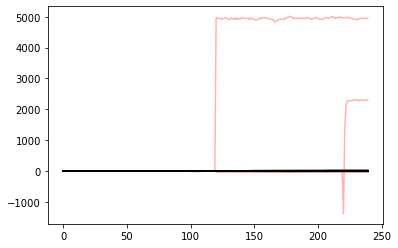

In [7]:
PVH_restricted_full, PVH_restricted_licks, PVH_restricted_runs, PVH_restricted_licks_in_runs, PVH_restricted_run_length = get_snips(PVH_restricted_dark)
PVH_dark_full, PVH_dark_licks, PVH_dark_runs, PVH_dark_licks_in_runs, PVH_dark_run_length = get_snips(PVH_adlib_dark)
PVH_light_full, PVH_light_licks, PVH_light_runs, PVH_light_licks_in_runs, PVH_light_run_length = get_snips(PVH_adlib_light)
PVH_sucralose_full, PVH_sucralose_licks, PVH_sucralose_runs, PVH_sucralose_licks_in_runs, PVH_sucralose_run_length = get_snips(PVH_adlib_sucralose)

VMH_restricted_full, VMH_restricted_licks, VMH_restricted_runs, VMH_restricted_licks_in_runs, VMH_restricted_run_length = get_snips(VMH_restricted_dark)
VMH_dark_full, VMH_dark_licks, VMH_dark_runs, VMH_dark_licks_in_runs,  VMH_dark_run_length = get_snips(VMH_adlib_dark)
VMH_light_full, VMH_light_licks, VMH_light_runs, VMH_light_licks_in_runs, VMH_light_run_length = get_snips(VMH_adlib_light)
VMH_sucralose_full, VMH_sucralose_licks, VMH_sucralose_runs, VMH_sucralose_licks_in_runs, VMH_sucralose_run_length = get_snips(VMH_adlib_sucralose)

In [8]:
#Combining data from mice with VMH and PVH placements

#COMBINED LICKS
restricted_licks = np.array(PVH_restricted_licks +VMH_restricted_licks)
dark_licks = np.array(PVH_dark_licks+ VMH_dark_licks)
light_licks = np.array(PVH_light_licks+ VMH_light_licks)
sucralose_licks = np.array(PVH_sucralose_licks+ VMH_sucralose_licks)

# COMBINED RUN NUMBER

restricted_runs = np.array(PVH_restricted_runs+VMH_restricted_runs)
dark_runs = np.array(PVH_dark_runs+ VMH_dark_runs)
light_runs = np.array(PVH_light_runs+ VMH_light_runs)
sucralose_runs = np.array(PVH_sucralose_runs+ VMH_sucralose_runs)

# COMBINED RUN LENGTH

restricted_run_length = np.array(PVH_restricted_run_length +VMH_restricted_run_length)
dark_run_length = np.array(PVH_dark_run_length+ VMH_dark_run_length)
light_run_length = np.array(PVH_light_run_length +VMH_light_run_length)
sucralose_run_length = np.array(PVH_sucralose_run_length+ VMH_sucralose_run_length)

# COMBINED LICKS IN RUNS

restricted_licks_in_runs= np.array(PVH_restricted_licks_in_runs +VMH_restricted_licks_in_runs)
dark_licks_in_runs = np.array(PVH_dark_licks_in_runs+ VMH_dark_licks_in_runs)
light_licks_in_runs = np.array(PVH_light_licks_in_runs +VMH_light_licks_in_runs)
sucralose_licks_in_runs = np.array(PVH_sucralose_licks_in_runs+ VMH_sucralose_licks_in_runs)

In [9]:
# Create a dictionary with combined arrays
data = {
    'restricted_licks': restricted_licks,
    'dark_licks': dark_licks,
    'light_licks': light_licks,
    'sucralose_licks': sucralose_licks,
    'restricted_runs': restricted_runs,
    'dark_runs': dark_runs,
    'light_runs': light_runs,
    'sucralose_runs': sucralose_runs,
    'restricted_run_length': restricted_run_length,
    'dark_run_length': dark_run_length,
    'light_run_length': light_run_length,
    'sucralose_run_length': sucralose_run_length,
    'restricted_licks_in_runs': restricted_licks_in_runs,
    'dark_licks_in_runs': dark_licks_in_runs,
    'light_licks_in_runs': light_licks_in_runs,
    'sucralose_licks_in_runs': sucralose_licks_in_runs
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

#save dictionary as a csv
file_path = STATSFOLDER / 'behavior_data_ALL.csv'

df.to_csv(file_path, index=False)

behavior bar graphs

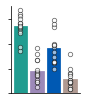

In [51]:
# number of licks per session 

f,ax=plt.subplots(figsize=(1.2,1.6))
f.subplots_adjust(wspace=0.4, left=0.1)

tp.barscatter([restricted_licks,
                light_licks,
                dark_licks,
                sucralose_licks],
              barfacecolor=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose],
              barfacecolor_option="individual",
              baredgecolor=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose],
              baredgecolor_option="individual",
              scattersize=20,
              scatteralpha=0.6,
              scatterlinecolor= "grey",
              ax=ax)

ax.set_yticklabels([])
#ax.set_ylim([0, 1800])
ax.set_yticks([0, 500, 1000, 1500])

f.savefig(FIGSFOLDER / "licks_per_session_ALL_2.pdf")

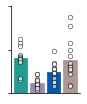

In [52]:
# number of runsper session 

f,ax=plt.subplots(figsize=(1.2,1.6))
f.subplots_adjust(wspace=0.4, left=0.1)

tp.barscatter([restricted_runs,
                light_runs,
                dark_runs,
                sucralose_runs],
              barfacecolor=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose],
              barfacecolor_option="individual",
              baredgecolor=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose],
              baredgecolor_option="individual",
              scattersize=20,
              scatteralpha=0.6,
              scatterlinecolor= "grey",
              ax=ax)

ax.set_yticklabels([])
ax.set_ylim([0, 40])
ax.set_yticks([0, 20, 40])

f.savefig(FIGSFOLDER / "runs_per_session_ALL_2.pdf")

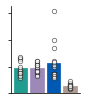

In [53]:
# run length (in seconds) per session 

f,ax=plt.subplots(figsize=(1.2,1.6))
f.subplots_adjust(wspace=0.4, left=0.1)

tp.barscatter([restricted_run_length,
                light_run_length,
                dark_run_length,
                sucralose_run_length],
              barfacecolor=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose],
              barfacecolor_option="individual",
              baredgecolor=[colors_restricted, colors_adlib_light, colors_adlib_dark, colors_sucralose],
              baredgecolor_option="individual",
              scattersize=20,
              scatteralpha=0.6,
              scatterlinecolor= "grey",
              ax=ax)

ax.set_yticklabels([])
ax.set_ylim([0, 65])
ax.set_yticks([0, 20, 40, 60])

f.savefig(FIGSFOLDER / "run_length_per_session_ALL_2.pdf")

for raster plot

In [13]:
def get_runs(onset, min_run_length=3, run_threshold=10):

    current_list = []
    runs = []
    
    for i in range(1, len(onset)):
        time_diff = (onset[i] - onset[i - 1])
        if time_diff <= run_threshold:
            current_list.append(onset[i])
        else:
            current_list = [onset[i]]
            runs.append(current_list)
            
    no_short_runs = []
    
    for run in runs:
        if len(run) > min_run_length-1:
            no_short_runs.append(run)
     
    time_zeroed_runs = []
    
    for run in no_short_runs:
        time_zeroed_runs.append([t-run[0] for t in run])

    return time_zeroed_runs

def get_runs_from_all (data):
    
    mice = get_list_of_mice(data)
    all_runs = []

    for mouse in mice:
        temp_runs = []
        for key, val in data.items():
            if val["mouse_ID"] == mouse:
                onset = val["licks"]
                temp_runs.append(get_runs(onset))

        all_runs.append(tp.flatten_list(temp_runs))

    return all_runs


def sort_runs(runs):
    sort_order = np.argsort([x[-1]for x in runs])
    runs_sorted = [runs[i] for i in sort_order]
    
    return runs_sorted

def get_run_lengths_for_pseudo_raster(runs, color="red"):
    lines = []
    for idx, trial in enumerate(runs):
            lines.append([(trial[0], idx), (trial[-1], idx)])
        
    return LineCollection(lines, color=color, linewidth=0.6)


In [14]:
PVH_restricted_runs2 = get_runs_from_all(PVH_restricted_dark)
VMH_restricted_runs2 = get_runs_from_all(VMH_restricted_dark)
restricted_runs2= PVH_restricted_runs2 +VMH_restricted_runs2

PVH_dark_runs2 = get_runs_from_all(PVH_adlib_dark)
VMH_dark_runs2 = get_runs_from_all(VMH_adlib_dark)
dark_runs2= PVH_dark_runs2 +VMH_dark_runs2

PVH_light_runs2 = get_runs_from_all(PVH_adlib_light)
VMH_light_runs2 = get_runs_from_all(VMH_adlib_light)
light_runs2= PVH_light_runs2 +VMH_light_runs2

PVH_sucralose_runs2 = get_runs_from_all(PVH_adlib_sucralose)
VMH_sucralose_runs2 = get_runs_from_all(VMH_adlib_sucralose)
sucralose_runs2= PVH_sucralose_runs2 +VMH_sucralose_runs2

restricted_sorted_runs = sort_runs(tp.flatten_list(restricted_runs2))
dark_sorted_runs = sort_runs(tp.flatten_list(dark_runs2))
light_sorted_runs = sort_runs(tp.flatten_list(light_runs2))
sucralose_sorted_runs = sort_runs(tp.flatten_list(sucralose_runs2))

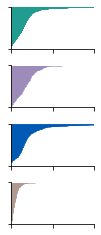

In [18]:
f,ax = plt.subplots(figsize=(1.5, 4),nrows=4, sharex = True, gridspec_kw={"hspace":0.4})

bins= np.arange(-5,40,1)
    
data_to_plot1 = get_run_lengths_for_pseudo_raster(restricted_sorted_runs, color=colors_restricted)
data_to_plot2 = get_run_lengths_for_pseudo_raster(light_sorted_runs, color=colors_adlib_light)
data_to_plot3 = get_run_lengths_for_pseudo_raster(dark_sorted_runs, color=colors_adlib_dark)
data_to_plot4 = get_run_lengths_for_pseudo_raster(sucralose_sorted_runs, color=colors_sucralose)

ax[0].add_collection(data_to_plot1)
ax[1].add_collection(data_to_plot2)
ax[2].add_collection(data_to_plot3)
ax[3].add_collection(data_to_plot4)

for axis in ax:
    axis.set_yticklabels([])
    axis.set_xticklabels([])

ax[0].set_yticks([0, len(restricted_sorted_runs)])
ax[1].set_yticks([0, len(light_sorted_runs)])
ax[2].set_yticks([0, len(dark_sorted_runs)])
ax[3].set_yticks([0, len(sucralose_sorted_runs)])

ax[0].set_xlim(0,100)
ax[1].set_xticks([0,50,100])


for ax in [ax[0],ax[1], ax[2], ax[3]]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

f.savefig(FIGSFOLDER / "raster_ALL.pdf")

In [22]:
print("number of runs in Restricted condition:", len(restricted_sorted_runs))
print("number of runs in Light condition", len(light_sorted_runs))
print("number of runs in Dark condition", len(dark_sorted_runs))
print("number of runs in Sucraloes condition", len(sucralose_sorted_runs))

number of runs in Restricted condition: 646
number of runs in Light condition 167
number of runs in Dark condition 253
number of runs in Sucraloes condition 279


lick frequency

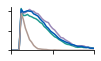

In [19]:
#For Lick frequency

def get_runs_from_all_2 (data):
    mice = get_list_of_mice(data)
    temp_runs = []
    
    for mouse in mice:
        for key, val in data.items():
            if val["mouse_ID"] == mouse:
                onset = val["licks"]
                temp_runs.append(get_runs(onset))

    all_runs = []
    for session in temp_runs:
        for run in session:
            all_runs.append(run)
            
    return all_runs

bins= np.arange(-5,40,1)

PVH_restricted_runs_3 = get_runs_from_all_2(PVH_restricted_dark)
VMH_restricted_runs_3 = get_runs_from_all_2(VMH_restricted_dark)
restricted_runs_3 = PVH_restricted_runs_3 + VMH_restricted_runs_3

restricted_hist = np.histogram(tp.flatten_list(restricted_runs_3), bins= bins)
restricted_freq = restricted_hist[0]/len(restricted_runs_3)

PVH_dark_runs_3 = get_runs_from_all_2(PVH_adlib_dark)
VMH_dark_runs_3 = get_runs_from_all_2(VMH_adlib_dark)
dark_runs_3 = PVH_dark_runs_3 + VMH_dark_runs_3

dark_hist = np.histogram(tp.flatten_list(dark_runs_3), bins= bins)
dark_freq = dark_hist[0]/len(dark_runs_3)

PVH_light_runs_3 = get_runs_from_all_2(PVH_adlib_light)
VMH_light_runs_3 = get_runs_from_all_2(VMH_adlib_light)
light_runs_3 = PVH_light_runs_3 + VMH_light_runs_3

light_hist = np.histogram(tp.flatten_list(light_runs_3), bins= bins)
light_freq = light_hist[0]/len(light_runs_3)

PVH_sucralose_runs_3 = get_runs_from_all_2(PVH_adlib_sucralose)
VMH_sucralose_runs_3 = get_runs_from_all_2(VMH_adlib_sucralose)
sucralose_runs_3 = PVH_sucralose_runs_3 + VMH_sucralose_runs_3

sucralose_hist = np.histogram(tp.flatten_list(sucralose_runs_3), bins= bins)
sucralose_freq = sucralose_hist[0]/len(sucralose_runs_3)

f, ax = plt.subplots(figsize=[1.5, 0.8])

ax.plot(restricted_freq, color=colors_restricted)
ax.plot(light_freq, color=colors_adlib_light)
ax.plot(dark_freq, color=colors_adlib_dark)
ax.plot(sucralose_freq,  color=colors_sucralose)

ax.set_xlim(0,40)
ax.set_xticks([0,20,40])

ax.set_ylim(0,5.6)
ax.set_yticks([0, 2.5, 5])

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

f.savefig(FIGSFOLDER / "lick_frequency_ALL.pdf")